## Training and Test on Swin Transformer
Training Swin as pretrained network using the combination of HAM and BCN.

#### INPUT
- **Training&Validation**: HAM+BCN. Without duplicates 
- **Test**: ISIC 2018 Challenge Test Set

In [1]:
# Install libraries

!pip install torch torchvision tensorboard
!pip install barbar
!pip install torchsummary
!pip install pytorch-ignite
!pip install timm

In [2]:
import torch
import os
import random
import torchvision
import pandas as pd
import torch.nn as nn
import numpy as np
from torchvision import transforms, datasets
from shutil import copyfile, move
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from barbar import Bar
from torchsummary import summary
from ignite.metrics import Accuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
import timm
from torch.utils.data import ConcatDataset

general_path = '/home/jovyan/shared/abulgheroni/'

In [3]:
def split_data(source, training, validation, split_size):    
    files = []
    for filename in os.listdir(source):
        file = source + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * split_size)
    validation_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    validation_set = shuffled_set[:validation_length]

    for filename in training_set:
        this_file = source + filename
        destination = training + filename
        copyfile(this_file, destination)

    for filename in validation_set:
        this_file = source + filename
        destination = validation + filename
        copyfile(this_file, destination)

## Data directories

In [5]:
source_MEL = '/home/jovyan/shared/abulgheroni/datasets/HAM10k_BCN20k_merged/HAM_BCN_merged/images/0.MEL/'
source_NV = '/home/jovyan/shared/abulgheroni/datasets/HAM10k_BCN20k_merged/HAM_BCN_merged/images/1.NV/'
source_BCC = '/home/jovyan/shared/abulgheroni/datasets/HAM10k_BCN20k_merged/HAM_BCN_merged/images/2.BCC/'
source_AKIEC = '/home/jovyan/shared/abulgheroni/datasets/HAM10k_BCN20k_merged/HAM_BCN_merged/images/3.AKIEC/'
source_BKL = '/home/jovyan/shared/abulgheroni/datasets/HAM10k_BCN20k_merged/HAM_BCN_merged/images/4.BKL/'
source_DF = '/home/jovyan/shared/abulgheroni/datasets/HAM10k_BCN20k_merged/HAM_BCN_merged/images/5.DF/'
source_VASC = '/home/jovyan/shared/abulgheroni/datasets/HAM10k_BCN20k_merged/HAM_BCN_merged/images/6.VASC/'

training_MEL = '/home/jovyan/shared/abulgheroni/datasets/HAM10k_BCN20k_merged/HAM_BCN_merged/images/training/0.MEL/'
training_NV = '/home/jovyan/shared/abulgheroni/datasets/HAM10k_BCN20k_merged/HAM_BCN_merged/images/training/1.NV/'
training_BCC = '/home/jovyan/shared/abulgheroni/datasets/HAM10k_BCN20k_merged/HAM_BCN_merged/images/training/2.BCC/'
training_AKIEC = '/home/jovyan/shared/abulgheroni/datasets/HAM10k_BCN20k_merged/HAM_BCN_merged/images/training/3.AKIEC/'
training_BKL = '/home/jovyan/shared/abulgheroni/datasets/HAM10k_BCN20k_merged/HAM_BCN_merged/images/training/4.BKL/'
training_DF = '/home/jovyan/shared/abulgheroni/datasets/HAM10k_BCN20k_merged/HAM_BCN_merged/images/training/5.DF/'
training_VASC = '/home/jovyan/shared/abulgheroni/datasets/HAM10k_BCN20k_merged/HAM_BCN_merged/images/training/6.VASC/'

validation_MEL = '/home/jovyan/shared/abulgheroni/datasets/HAM10k_BCN20k_merged/HAM_BCN_merged/images/validation/0.MEL/'
validation_NV = '/home/jovyan/shared/abulgheroni/datasets/HAM10k_BCN20k_merged/HAM_BCN_merged/images/validation/1.NV'
validation_BCC = '/home/jovyan/shared/abulgheroni/datasets/HAM10k_BCN20k_merged/HAM_BCN_merged/images/validation/2.BCC/'
validation_AKIEC = '/home/jovyan/shared/abulgheroni/datasets/HAM10k_BCN20k_merged/HAM_BCN_merged/images/validation/3.AKIEC/'
validation_BKL = '/home/jovyan/shared/abulgheroni/datasets/HAM10k_BCN20k_merged/HAM_BCN_merged/images/validation/4.BKL/'
validation_DF = '/home/jovyan/shared/abulgheroni/datasets/HAM10k_BCN20k_merged/HAM_BCN_merged/images/validation/5.DF/'
validation_VASC = '/home/jovyan/shared/abulgheroni/datasets/HAM10k_BCN20k_merged/HAM_BCN_merged/images/validation/6.VASC/'

##
### Dataset has some photos of the same skin neoplasms but slightly rescaled.  
### Neoplasms are identified by lesion_id.   
###  We will read into the csv file with info about dataset and drop all duplicate photos by lesion_id to make all our photos iid (independant and identically distributed), so that we wont overfit and wont randomly put duplicate photos into validation set. 

In [6]:
data = pd.read_csv(r'/home/jovyan/shared/abulgheroni/datasets/HAM10k_BCN20k_merged/HAM_BCN_enlarged.csv')

In [7]:
data.head()

,lesion_id,image_id,enlarged_diagnosis,source,age,null_age,sex,null_sex,localization,null_localization
0,HAM_0000000,ISIC_0025346,NV,HAM,60.0,1,male,1,back,1.0
1,HAM_0000000,ISIC_0028498,NV,HAM,60.0,1,male,1,back,1.0
2,HAM_0000001,ISIC_0027859,BKL,HAM,70.0,1,female,1,face,1.0
3,HAM_0000002,ISIC_0032622,MEL,HAM,65.0,1,female,1,lower,NaN
4,HAM_0000002,ISIC_0033848,MEL,HAM,65.0,1,female,1,lower,NaN


In [8]:
data.columns

Index(['lesion_id', 'image_id', 'enlarged_diagnosis', 'source', 'age',
       'null_age', 'sex', 'null_sex', 'localization', 'null_localization'],
      dtype='object')

In [9]:
len(data)

22428

In [10]:
data = data.drop_duplicates(subset='lesion_id')

In [11]:
len(data)

11046

##
###  Now using list comprehensions we will save all image names and their diagnosis in variables, and using for loop we will sort and copy all files by their diagnosis into the corresponding folders.
### Then we will split each individual class of photos into train and val datasets 80/20%.

In [12]:
image_names = [x for x in data['image_id']]
diagnosis = [x for x in data['enlarged_diagnosis']]

In [13]:
print(len(image_names))
print(len(diagnosis))

11046
11046


In [14]:
print(image_names[0])
print(diagnosis[0])

ISIC_0025346
NV


In [15]:
print(type(image_names[0]))
print(type(diagnosis[0]))


<class 'str'>
<class 'str'>


In [16]:
pd.unique(data['enlarged_diagnosis'])

array(['NV', 'BKL', 'MEL', 'AKIEC', 'BCC', 'DF', 'VASC'], dtype=object)

In [17]:
# Print amount of pictures for each class
print(len(os.listdir(source_MEL)))
print(len(os.listdir(source_NV)))
print(len(os.listdir(source_BCC)))
print(len(os.listdir(source_AKIEC)))
print(len(os.listdir(source_BKL)))
print(len(os.listdir(source_DF)))
print(len(os.listdir(source_VASC)))

1138
6684
1310
586
1080
113
135


In [18]:
traindir_HAM = r'/home/jovyan/nfs/igallo/datasets/HAM10000/skin/training/'
valdir_HAM = r'/home/jovyan/nfs/igallo/datasets/HAM10000/skin/validation/'

traindir_BCN = r'/home/jovyan/nfs/mgallazzi/datasets/BCN20k_noDuplicati/BCN/images/training/'
valdir_BCN = r'/home/jovyan/nfs/mgallazzi/datasets/BCN20k_noDuplicati/BCN/images/validation/'

## __3. Data augmentation.__
### The Dataset contains 7470 distinct images (eliminated duplicates - HAM10000 images only) of size 400x600. Apart from image analysis (most have the area of interest in the center of the image), Data Augmentation focuses on trying not to alter the scale of the image. This in fact, could alter the symmetries, shape and size of the mole and consequently, give the network incorrect information about the nature of the neoplasm.
### Therefore, a resize to 56% of the original size and a randomCrop hit of size 224x224 was chosen.
### In addition, to give more information to the network, horizontal flip (p = 0.50) and image translation (p = 0.50) was applied.
### Finally, with p = 0.10, a 20% contrast enhancement is applied to the image to also 'play' with the image colors and train the network to correctly classify images of each type.


In [19]:
scale_factor = 0.56

HAM_train_transforms = transforms.Compose([
    
    transforms.Resize((int(600 * scale_factor), int(450 * scale_factor))),  # Rescale the image to 50% while maintaining the scaled image
    transforms.RandomCrop((224, 224)),  # randomCrop 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply(transforms=[transforms.RandomRotation(degrees=(-180, 180))], p=0.99),
    
    # Random rotation with range of +/-10% compared to the original size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

HAM_val_transforms = transforms.Compose([
    
    transforms.Resize((int(600 * scale_factor), int(450 * scale_factor))),  
    transforms.RandomCrop((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

BCN_train_transforms = transforms.Compose([
    
    transforms.Resize((612, 612)), 
    transforms.RandomCrop((600, 450)),  
    transforms.Resize((int(600 * scale_factor), int(450 * scale_factor))),  
    transforms.RandomCrop((224, 224)),  #
    transforms.RandomHorizontalFlip(p=0.5),
    

    transforms.RandomApply(transforms=[transforms.RandomRotation(degrees=(-180, 180))], p=0.99),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

BCN_val_transforms = transforms.Compose([
    
    transforms.Resize((612, 612)),  
    transforms.RandomCrop((600, 450)),  
    transforms.Resize((int(600 * scale_factor), int(450 * scale_factor))),  
    transforms.RandomCrop((224, 224)),  # Applico il randomCrop a 224x22
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

HAM_train_dataset = datasets.ImageFolder(
    traindir_HAM, transform = HAM_train_transforms)

HAM_val_dataset = datasets.ImageFolder(
    valdir_HAM, transform = HAM_val_transforms)

BCN_train_dataset = datasets.ImageFolder(
    traindir_BCN, transform = BCN_train_transforms)

BCN_val_dataset = datasets.ImageFolder(
    valdir_BCN, transform = BCN_val_transforms)

train_dataset = ConcatDataset([HAM_train_dataset, BCN_train_dataset])
val_dataset = ConcatDataset([HAM_val_dataset, BCN_val_dataset])

## 4.Training
#### Model definition
#### Define final layer to a 7 way linear classifier
#### Choose Cross Entropy loss function
#### Adam optimizer (with 0.0001 weight decay)
#### The epoch number will be set to 999 since we will be using early stopping.
####

In [21]:
model = timm.create_model('swin_large_patch4_window7_224', pretrained=True, num_classes = 7)

In [22]:
num_classes = 7 


in_features = model.head.in_features  
model.head = nn.Linear(in_features, num_classes)  

for param in model.parameters():
    param.requires_grad = True 


for param in model.head.parameters():
    param.requires_grad = True

#### Early stopping reduces validation loss, and 20 was selected as the patience threshold. This large number is justified because, during the project's development, the model was trained in other experiments. After different experiments, we saw the model continues to gradually reduce training loss without overfitting; however, validation loss moves rather stochastically, so in order to avoid stopping the model too soon, a 20-epoch patience period was chosen.
####

In [24]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1)


device = torch.device("cuda:0")

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    print('Start training...')
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.view(outputs.size(0), -1)
            
        # print('Shape of outputs: ' , outputs.shape)
        # print('Shape of labels: ' , labels.shape)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    return train_loss, train_acc

def validate(model, val_loader, criterion, device):
    print('Start validation...')
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            outputs = outputs.view(outputs.size(0), -1)
            
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    return val_loss, val_acc, all_labels, all_predictions

best_val_loss = float('inf')
early_stopping_counter = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(999):  # Set the number of epochs
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, all_labels, all_predictions = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    if val_loss < best_val_loss:
        print("Validation loss decreased, saving model...")
        best_val_loss = val_loss
        torch.save(model.state_dict(), r'/home/jovyan/shared/abulgheroni/output/best_swin_large_train_5_5.pt')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        
    if early_stopping_counter >= 30:
        print("Early stopping triggered")
        break


Start training...


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392026823/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Start validation...
Epoch 1, Train Loss: 1.1691, Train Acc: 0.6583, Val Loss: 0.7658, Val Acc: 0.7417
Validation loss decreased, saving model...
Start training...
Start validation...
Epoch 2, Train Loss: 0.5946, Train Acc: 0.7868, Val Loss: 0.4860, Val Acc: 0.8390
Validation loss decreased, saving model...
Start training...
Start validation...
Epoch 3, Train Loss: 0.4738, Train Acc: 0.8253, Val Loss: 0.3833, Val Acc: 0.8650
Validation loss decreased, saving model...
Start training...
Start validation...
Epoch 4, Train Loss: 0.4192, Train Acc: 0.8461, Val Loss: 0.3170, Val Acc: 0.8935
Validation loss decreased, saving model...
Start training...
Start validation...
Epoch 5, Train Loss: 0.3612, Train Acc: 0.8688, Val Loss: 0.3066, Val Acc: 0.8935
Validation loss decreased, saving model...
Start training...
Start validation...
Epoch 6, Train Loss: 0.3168, Train Acc: 0.8816, Val Loss: 0.2658, Val Acc: 0.9058
Validation loss decreased, saving model...
Start training...
Start validation...
Ep

## Results
#### Model stopped training after 155 epochs with Early stopping method. 

#### Now we will look at confusion matrix and classification report with Precision, Recall, and F1 score.
####

In [25]:
# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_names):
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap='Blues', cbar=False)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()

# Function to plot training and validation accuracy and loss
def plot_metrics(train_accuracies, val_accuracies, train_losses, val_losses):
    epochs = range(1, len(train_accuracies) + 1)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

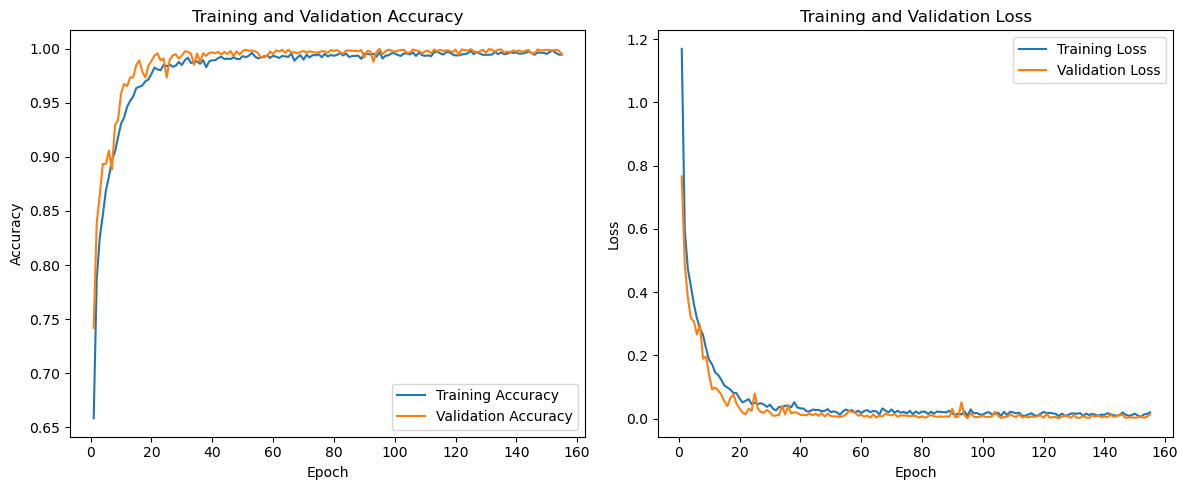

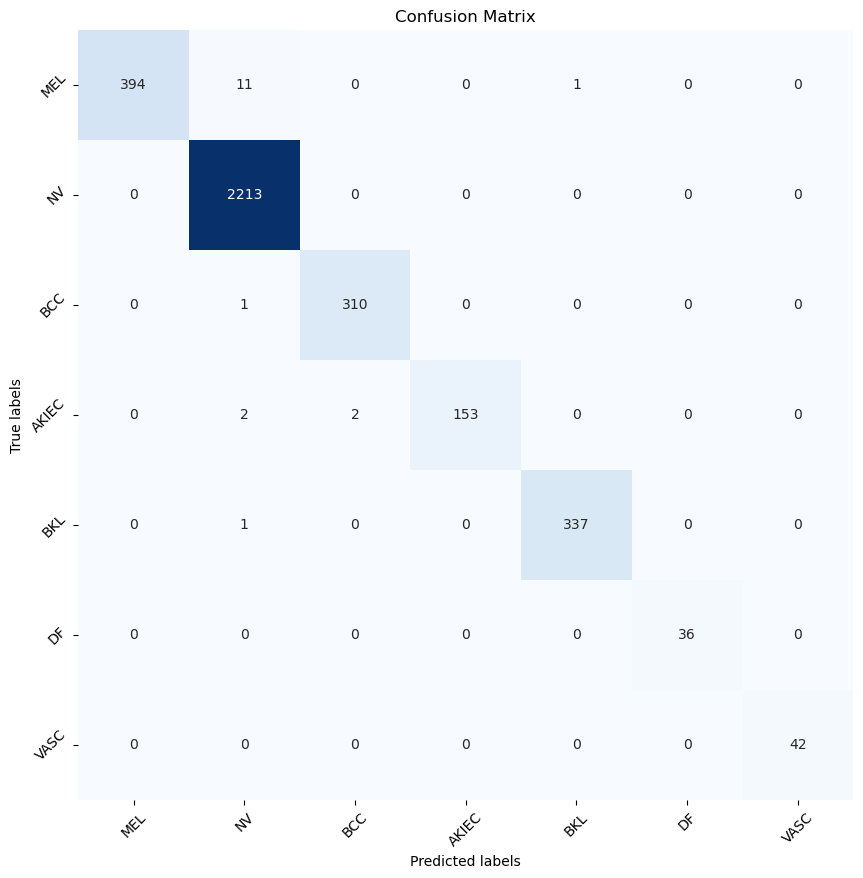

In [26]:
# After training completes, plot the metrics and confusion matrix
plot_metrics(train_accuracies, val_accuracies, train_losses, val_losses)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
# Convert all_labels and all_predictions to the correct format if necessary
class_names = {0: 'MEL', 1: 'NV', 2: 'BCC', 3:'AKIEC', 4:'BKL', 5:'DF', 6:'VASC'}  # Esempio di dizionario di mapping
class_names = list(class_names.values())
#class_names = val_dataset.classes
plot_confusion_matrix(conf_matrix, class_names)

## Test
#### We use the test dataset discussed in the paper (HAM Test) to see how the model ranks never-before-seen images. The dataset consists of 1511 images divided into seven classes. 
####

In [27]:
testdir = '/home/jovyan/nfs/mgallazzi/datasets/HAM10k_test_Duplicati/divided/'

In [29]:
test_transforms = transforms.Compose([
    
    transforms.Resize((int(600 * scale_factor), int(450 * scale_factor))),  # Rescalo l'immagine al 50% mantenendo l'immagine in scala
    transforms.CenterCrop((224, 224)),  # Applico il randomCrop a 224x224
  
    #transforms.RandomCrop((224, 224)),  # Applico il randomCrop a 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_dataset = datasets.ImageFolder(
    testdir, transform=test_transforms)


In [30]:
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=128, shuffle=True,
    pin_memory=False, drop_last=False, num_workers=1)

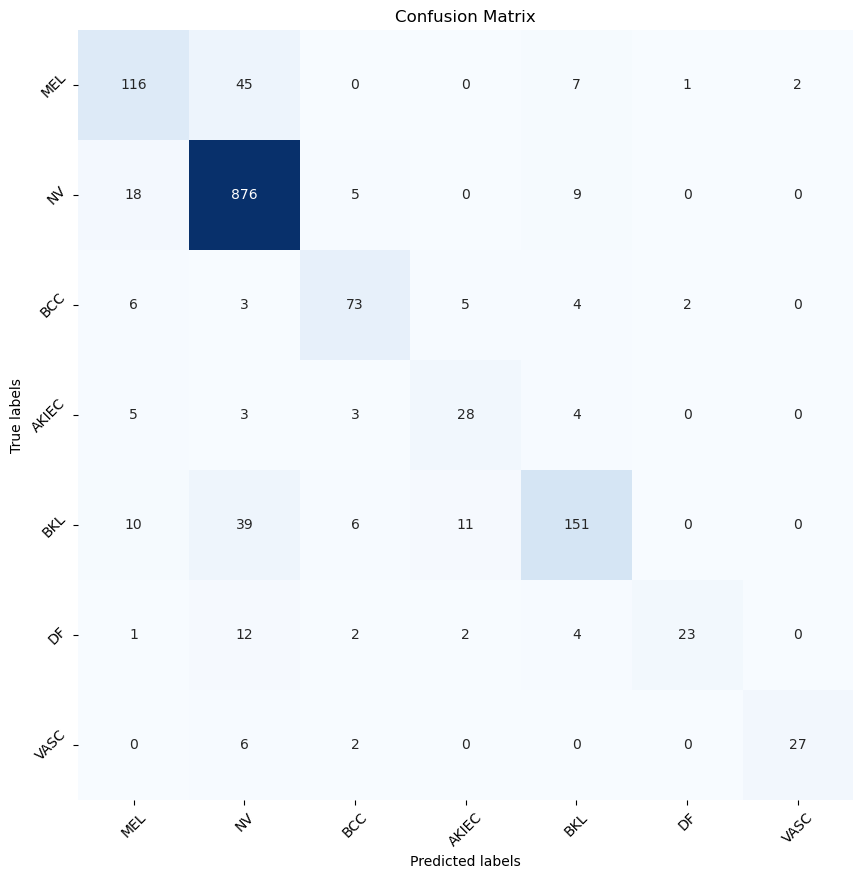

              precision    recall  f1-score   support

         MEL       0.74      0.68      0.71       171
          NV       0.89      0.96      0.93       908
         BCC       0.80      0.78      0.79        93
       AKIEC       0.61      0.65      0.63        43
         BKL       0.84      0.70      0.76       217
          DF       0.88      0.52      0.66        44
        VASC       0.93      0.77      0.84        35

    accuracy                           0.86      1511
   macro avg       0.81      0.72      0.76      1511
weighted avg       0.85      0.86      0.85      1511



In [32]:
import torchvision.models as models

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = timm.create_model('swin_large_patch4_window7_224', pretrained=False) # pretrained=False since we'll load custom weights

# Modify the last layer to match the training architecture
in_features = model.head.in_features  # Get the input size of the last linear layer
model.head = nn.Linear(in_features, num_classes)  # Replace the old layer with a new one

# Load the trained model weights
model_path = '/home/jovyan/shared/abulgheroni/output/best_swin_large_train_5_5.pt'
model.load_state_dict(torch.load(model_path, map_location=device))

# Move the model to the appropriate device
model = model.to(device)

# Evaluation mode
model.eval()

num_classes = 7

predlist_test=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist_test=torch.zeros(0,dtype=torch.long, device='cpu')
predlistauc_test = torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        model.eval() 
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        outputs = outputs.view(outputs.size(0), -1)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist_test = torch.cat([predlist_test, preds.view(-1).cpu()])
        lbllist_test = torch.cat([lbllist_test, classes.view(-1).cpu()])
        predlistauc_test = torch.cat([predlistauc_test, nn.functional.softmax(outputs, dim=1).cpu()])

# Conversion of tensors to numpy for further processing
predlist_test = predlist_test.numpy()
lbllist_test = lbllist_test.numpy()
predlistauc_test = predlistauc_test.numpy()

# Confusion matrix, classification report

# Confusion Matrix
conf_matrix = confusion_matrix(lbllist_test, predlist_test)
# Convert all_labels and all_predictions to the correct format if necessary
class_names = {0: 'MEL', 1: 'NV', 2: 'BCC', 3:'AKIEC', 4:'BKL', 5:'DF', 6:'VASC'}  
class_names = list(class_names.values())
plot_confusion_matrix(conf_matrix, class_names)

print(classification_report(lbllist_test, predlist_test, target_names=class_names))

## IMPORTANT: the result values are in decimal values. To obtain the exactly same value presented in the paper (85.64) you need to sum all the values on the diagonal and divid the result to 1511.

### N.B. The result showned in this notebook referes to the experiment MEL8_5

### Accuravy_value_in_paper = (116+876+73+28+151+23+27) / 1511 --> 85.64